# **Laboratory Task 6**

Instruction: Convert the following CNN architecture diagram into a PyTorch CNN Architecture.

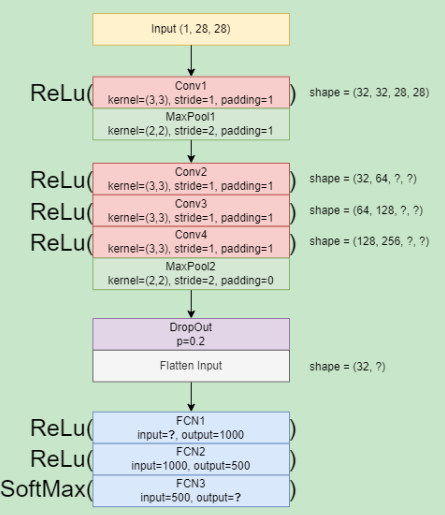

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean/std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

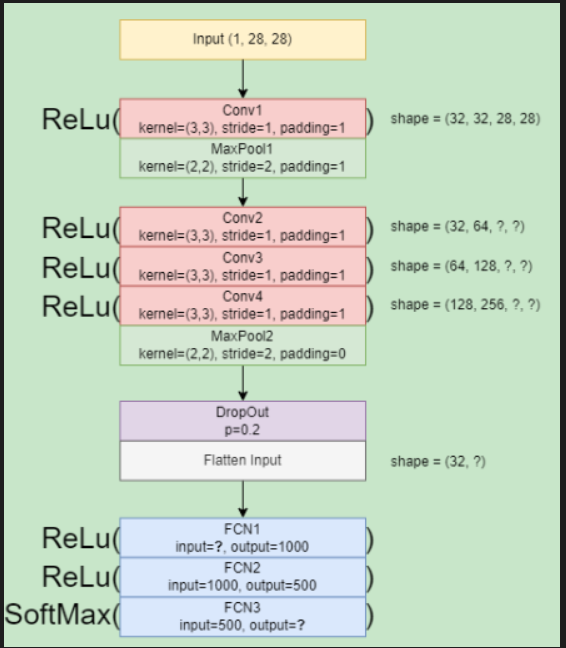

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):  # You can change num_classes
        super(CNN, self).__init__()
        
        # --- Convolutional Block 1 ---
        # Input: (1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Output after conv1: (32, 28, 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        # Output after pool1: (32, 15, 15)
        
        # --- Convolutional Block 2 ---
        # Input: (32, 15, 15)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Output after conv2: (64, 15, 15)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Output after conv3: (128, 15, 15)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # Output after conv4: (256, 15, 15)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Output after pool2: (256, 7, 7)
        
        # --- Dropout and Flatten ---
        self.dropout = nn.Dropout(p=0.2)
        # Flattened size = 256 * 7 * 7 = 12544
        
        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(256 * 7 * 7, 1000)
        # Output: (1000,)
        self.fc2 = nn.Linear(1000, 500)
        # Output: (500,)
        self.fc3 = nn.Linear(500, num_classes)
        # Output: (num_classes,)
        
    def forward(self, x):
        # Convolution Block 1
        x = F.relu(self.conv1(x))       # (1,28,28) -> (32,28,28)
        x = self.pool1(x)               # (32,28,28) -> (32,15,15)
        
        # Convolution Block 2
        x = F.relu(self.conv2(x))       # (32,15,15) -> (64,15,15)
        x = F.relu(self.conv3(x))       # (64,15,15) -> (128,15,15)
        x = F.relu(self.conv4(x))       # (128,15,15) -> (256,15,15)
        x = self.pool2(x)               # (256,15,15) -> (256,7,7)
        
        # Flatten and Dropout
        x = self.dropout(x)
        x = torch.flatten(x, 1)         # (256,7,7) -> (12544,)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))         # -> (1000,)
        x = F.relu(self.fc2(x))         # -> (500,)
        x = F.softmax(self.fc3(x), dim=1)  # -> (num_classes,)
        return x

In [4]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=12544, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/50] - Loss: 1.7784


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 8.92%
